
--- 1. Investment Thesis & Parameters (SMA Crossover) ---

Formulate and test a trend-following strategy based on Moving Average (MA) crossovers.
Hypothesis: A strategy that buys when a short-term MA crosses above a long-term MA,
and sells (or goes flat) when the short-term MA crosses below the long-term MA,
can outperform a simple buy-and-hold strategy by capturing significant trends and
potentially avoiding some market downturns.

Target Ticker: SPY
Test Period: 2015-05-08 to 2025-05-07
Short MA Window: 50, Long MA Window: 200
Initial Capital: $100,000.00

--- 2. Data Acquisition ---
Fetching historical data for SPY from 2015-05-08 to 2025-05-07 using yfinance...
Data successfully loaded. Actual period: 2015-05-08 to 2025-05-06
Data shape: (2514, 5)

--- 3. Feature Engineering: Calculating SMAs ---

--- 4. Signal Generation ---
Trading signals generated.

--- 5. Position Management & Backtesting ---
Backtesting complete.

--- 6. Performance Evaluation ---
Initial Capital: $100,000.0

C:\Users\91909\AppData\Local\Temp\ipykernel_1612\1951921962.py:234: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax1.plot(buy_signals.index, data.loc[buy_signals.index, 'SMA_short'],


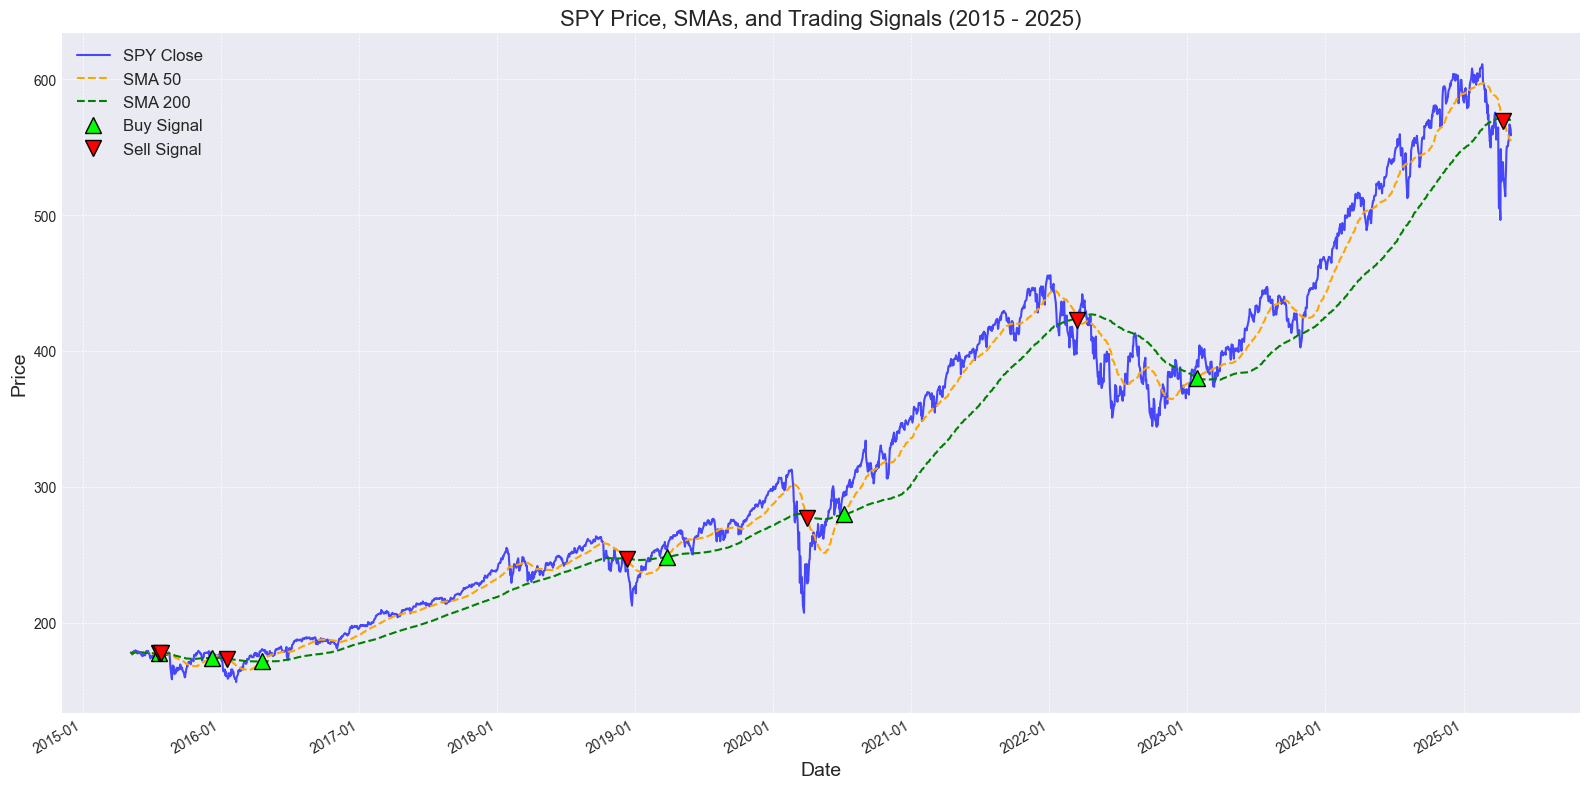

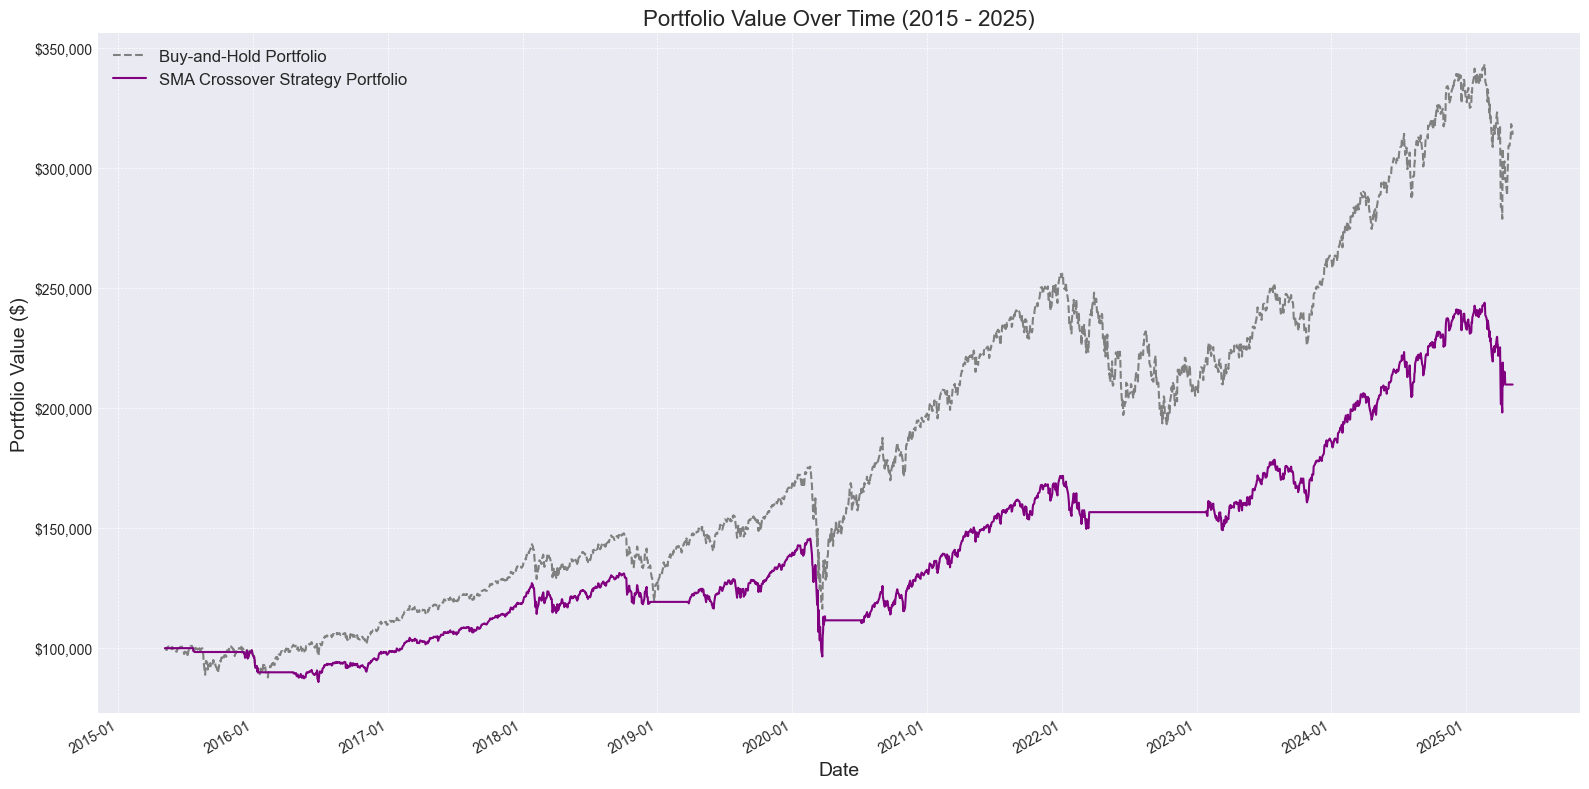


--- 8. Hypothesis Testing (Qualitative Analysis) ---
Recall Investment Thesis:

Formulate and test a trend-following strategy based on Moving Average (MA) crossovers.
Hypothesis: A strategy that buys when a short-term MA crosses above a long-term MA,
and sells (or goes flat) when the short-term MA crosses below the long-term MA,
can outperform a simple buy-and-hold strategy by capturing significant trends and
potentially avoiding some market downturns.


Observations:
- Strategy total return (109.81%) underperformed Buy-and-Hold (213.84%).
- Strategy CAGR (7.70%) was lower than Buy-and-Hold (12.12%).
- Strategy risk-adjusted return (Sharpe: 0.44) was worse than Buy-and-Hold (Sharpe: 0.61).
- Strategy experienced a larger/similar maximum drawdown (-33.72%) vs Buy-and-Hold (-33.72%).

Conclusion regarding hypothesis:
The SMA crossover strategy did NOT consistently outperform buy-and-hold. Hypothesis not strongly supported by this test.

Caveats: Past performance is not future indicative

In [17]:
# --- 0. IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import yfinance as yf # Using yfinance for data
import matplotlib.dates as mdates # Import for explicit date formatting

# --- 1. INVESTMENT THESIS & PARAMETERS ---
print("\n--- 1. Investment Thesis & Parameters (SMA Crossover) ---")
INVESTMENT_THESIS = """
Formulate and test a trend-following strategy based on Moving Average (MA) crossovers.
Hypothesis: A strategy that buys when a short-term MA crosses above a long-term MA,
and sells (or goes flat) when the short-term MA crosses below the long-term MA,
can outperform a simple buy-and-hold strategy by capturing significant trends and
potentially avoiding some market downturns.
"""
print(INVESTMENT_THESIS)

# Strategy Parameters
TICKER = "SPY"  # Example: S&P 500 ETF. For NSE: "INFY.NS", "RELIANCE.NS"
END_DATE_DT = datetime.today()
START_DATE_DT = END_DATE_DT - timedelta(days=10 * 365.25) # Approx 10 years

END_DATE_STR = END_DATE_DT.strftime('%Y-%m-%d')
START_DATE_STR = START_DATE_DT.strftime('%Y-%m-%d')

SHORT_WINDOW = 50
LONG_WINDOW = 200
INITIAL_CAPITAL = 100000.0
RISK_FREE_RATE_ANNUAL = 0.02

print(f"Target Ticker: {TICKER}")
print(f"Test Period: {START_DATE_STR} to {END_DATE_STR}")
print(f"Short MA Window: {SHORT_WINDOW}, Long MA Window: {LONG_WINDOW}")
print(f"Initial Capital: ${INITIAL_CAPITAL:,.2f}")

# --- 2. DATA ACQUISITION using yfinance (with MultiIndex fix) ---
print("\n--- 2. Data Acquisition ---")
print(f"Fetching historical data for {TICKER} from {START_DATE_STR} to {END_DATE_STR} using yfinance...")
data = pd.DataFrame()
price_column = None

try:
    raw_data = yf.download(TICKER, start=START_DATE_STR, end=END_DATE_STR, progress=False)
    if raw_data.empty: raise ValueError(f"No data fetched for {TICKER}.")

    if isinstance(raw_data.columns, pd.MultiIndex):
        data = raw_data.droplevel(level=1, axis=1)
    else:
        data = raw_data

    # Ensure data index is DatetimeIndex
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)
        print("Converted data index to DatetimeIndex in Data Acquisition.")


    if 'Adj Close' in data.columns and not data['Adj Close'].isnull().all():
        price_column = 'Adj Close'
    elif 'Close' in data.columns and not data['Close'].isnull().all():
        price_column = 'Close'
        print("Warning: 'Adj Close' not found or all NaN. Using 'Close' as price_column.")
    else:
        raise ValueError("Neither 'Adj Close' nor 'Close' column found with valid data.")
        
    print(f"Data successfully loaded. Actual period: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}")
    print(f"Data shape: {data.shape}")

except Exception as e:
    print(f"ERROR during data acquisition or processing: {e}")
    data = pd.DataFrame(); price_column = None


# --- 3. FEATURE ENGINEERING: Calculate SMAs ---
if not data.empty and price_column is not None:
    print("\n--- 3. Feature Engineering: Calculating SMAs ---")
    try:
        data['SMA_short'] = data[price_column].rolling(window=SHORT_WINDOW, min_periods=1).mean()
        data['SMA_long'] = data[price_column].rolling(window=LONG_WINDOW, min_periods=1).mean()
        if 'SMA_short' in data.columns and 'SMA_long' in data.columns:
            # Drop rows if SMAs could not be calculated (e.g., if price_column had leading NaNs not handled)
            # With min_periods=1 this usually means the price_column itself was problematic.
            data.dropna(subset=['SMA_short', 'SMA_long'], inplace=True)
            if data.empty: print("ERROR: Data became empty after dropna on SMAs. Check for NaNs in price data.")
        else:
            print("ERROR: SMA columns not created successfully.")
            data = pd.DataFrame()
    except Exception as e_sma:
        print(f"ERROR during SMA calculation: {e_sma}")
        data = pd.DataFrame()
else:
    if data.empty: print("Skipping feature engineering: No data.")
    elif price_column is None: print("Skipping feature engineering: No valid price column.")

# --- 4. SIGNAL GENERATION ---
if not data.empty and 'SMA_short' in data.columns and 'SMA_long' in data.columns:
    print("\n--- 4. Signal Generation ---")
    data['Signal'] = 0
    buy_condition = (data['SMA_short'] > data['SMA_long']) & (data['SMA_short'].shift(1) <= data['SMA_long'].shift(1))
    data.loc[buy_condition, 'Signal'] = 1
    sell_condition = (data['SMA_short'] < data['SMA_long']) & (data['SMA_short'].shift(1) >= data['SMA_long'].shift(1))
    data.loc[sell_condition, 'Signal'] = -1
    print("Trading signals generated.")
else:
    print("Skipping signal generation.")

# --- 5. POSITION MANAGEMENT & BACKTESTING ---
if not data.empty and 'Signal' in data.columns and price_column in data.columns:
    print("\n--- 5. Position Management & Backtesting ---")
    data['Position'] = 0
    current_position = 0
    for i in range(len(data)):
        signal_today = data['Signal'].iloc[i]
        if signal_today == 1: current_position = 1
        elif signal_today == -1: current_position = 0
        data.loc[data.index[i], 'Position'] = current_position
    data['Position'] = data['Position'].shift(1).fillna(0)

    data['Market_Returns'] = data[price_column].pct_change()
    data['Market_Returns'] = data['Market_Returns'].fillna(0) # Address FutureWarning
        
    data['Strategy_Returns'] = data['Market_Returns'] * data['Position']

    data['Cumulative_Market_Returns'] = (1 + data['Market_Returns']).cumprod()
    data['Cumulative_Strategy_Returns'] = (1 + data['Strategy_Returns']).cumprod()
    data['Market_Portfolio'] = INITIAL_CAPITAL * data['Cumulative_Market_Returns']
    data['Strategy_Portfolio'] = INITIAL_CAPITAL * data['Cumulative_Strategy_Returns']
    print("Backtesting complete.")
else:
    print("Skipping backtesting.")


# --- 6. PERFORMANCE EVALUATION ---
years = 0
if not data.empty and 'Strategy_Portfolio' in data.columns and price_column in data.columns:
    print("\n--- 6. Performance Evaluation ---")
    if len(data) < max(SHORT_WINDOW, LONG_WINDOW) or len(data) < 2:
        print("Warning: Not enough data for robust performance evaluation.")
    else:
        final_market_value = data['Market_Portfolio'].iloc[-1]
        final_strategy_value = data['Strategy_Portfolio'].iloc[-1]
        total_market_return_pct = (final_market_value / INITIAL_CAPITAL) - 1
        total_strategy_return_pct = (final_strategy_value / INITIAL_CAPITAL) - 1

        print(f"Initial Capital: ${INITIAL_CAPITAL:,.2f}")
        print(f"Final Buy-and-Hold Portfolio Value: ${final_market_value:,.2f} (Return: {total_market_return_pct:.2%})")
        print(f"Final Strategy Portfolio Value: ${final_strategy_value:,.2f} (Return: {total_strategy_return_pct:.2%})")

        start_date_actual, end_date_actual = data.index[0], data.index[-1]
        days_in_data = (end_date_actual - start_date_actual).days
        years = days_in_data / 365.25 if days_in_data > 0 else 0

        if years > 0.5:
            cagr_market = (data['Cumulative_Market_Returns'].iloc[-1])**(1/years) - 1
            cagr_strategy = (data['Cumulative_Strategy_Returns'].iloc[-1])**(1/years) - 1
            volatility_market = data['Market_Returns'].std() * np.sqrt(252)
            volatility_strategy = data['Strategy_Returns'].std() * np.sqrt(252)
            
            daily_rf_rate = (1 + RISK_FREE_RATE_ANNUAL)**(1/252) - 1
            # Ensure means are calculated on non-empty series before multiplying by 252
            mean_market_daily_excess_ret = (data['Market_Returns'] - daily_rf_rate).mean() if not data['Market_Returns'].empty else 0
            mean_strategy_daily_excess_ret = (data['Strategy_Returns'] - daily_rf_rate).mean() if not data['Strategy_Returns'].empty else 0

            sharpe_market = (mean_market_daily_excess_ret * 252) / volatility_market if volatility_market > 1e-9 else 0
            sharpe_strategy = (mean_strategy_daily_excess_ret * 252) / volatility_strategy if volatility_strategy > 1e-9 else 0


            print(f"Annualized Buy-and-Hold Return (CAGR): {cagr_market:.2%}")
            print(f"Annualized Strategy Return (CAGR): {cagr_strategy:.2%}")
            print(f"Annualized Buy-and-Hold Volatility: {volatility_market:.2%}")
            print(f"Annualized Strategy Volatility: {volatility_strategy:.2%}")
            print(f"Buy-and-Hold Sharpe Ratio (Rf={RISK_FREE_RATE_ANNUAL*100:.1f}%): {sharpe_market:.2f}")
            print(f"Strategy Sharpe Ratio (Rf={RISK_FREE_RATE_ANNUAL*100:.1f}%): {sharpe_strategy:.2f}")
        else:
            print("Period too short for meaningful annualized metrics.")
            cagr_market, cagr_strategy, sharpe_market, sharpe_strategy = (0,)*4

        def calculate_max_drawdown_from_daily_returns(daily_returns_series):
            if daily_returns_series.empty or daily_returns_series.isnull().all():
                return 0.0
            cumulative_returns = (1 + daily_returns_series).cumprod()
            # Ensure cumulative_returns doesn't start with or become non-positive if daily_returns are extreme
            if cumulative_returns.iloc[0] <= 0 and len(cumulative_returns) > 1:
                # Attempt to re-base if first element is problematic, assumes subsequent are okay
                # This is a tricky edge case, ideally daily returns won't be -100% on day 1
                print("Warning: Cumulative returns started non-positive in drawdown calc.")
                # A more robust fix might involve clipping daily returns or handling the first element.
                # For now, if it's just the first element, let cummax handle it by possibly starting peak later.
                pass

            peak = cumulative_returns.cummax()
            # Prevent division by zero or issues if peak becomes non-positive
            peak = peak.replace(0, np.nan).ffill() # Replace 0s with NaN then ffill
            if peak.isnull().all() or (peak <= 0).any(): # If peak is still problematic
                 print("Warning: Peak values in drawdown calculation are non-positive or all NaN.")
                 return -1.0 # Indicate max possible drawdown or error

            drawdown = (cumulative_returns - peak) / peak
            return drawdown.min()

        max_dd_market = calculate_max_drawdown_from_daily_returns(data['Market_Returns'])
        max_dd_strategy = calculate_max_drawdown_from_daily_returns(data['Strategy_Returns'])
        print(f"Buy-and-Hold Max Drawdown: {max_dd_market:.2%}")
        print(f"Strategy Max Drawdown: {max_dd_strategy:.2%}")

        num_trades = data['Signal'][data['Signal'] != 0].count()
        print(f"Number of Trades (signals generated): {num_trades}")
else:
    print("Skipping performance evaluation.")
    cagr_strategy, sharpe_strategy, total_strategy_return_pct = (0,0,0)
    cagr_market, sharpe_market, total_market_return_pct, max_dd_market, max_dd_strategy = (0,0,0,0,0)

# --- 7. VISUALIZATION ---
if not data.empty and 'Strategy_Portfolio' in data.columns and 'SMA_short' in data.columns and price_column in data.columns:
    print("\n--- 7. Visualization ---")
    plt.style.use('seaborn-v0_8-darkgrid') # Using a seaborn style

    # Plot 1: Price, SMAs, and Trading Signals
    fig1, ax1 = plt.subplots(figsize=(16, 8)) # Use fig1, ax1

    # --- Apply explicit date formatting for ax1 ---
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) # Format as Year-Month
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=6, maxticks=12)) # Auto ticks
    fig1.autofmt_xdate(rotation=45) # Rotate date labels for readability
    # --- End of date formatting ---

    data[price_column].plot(ax=ax1, label=f'{TICKER} {price_column}', alpha=0.7, color='blue')
    data['SMA_short'].plot(ax=ax1, label=f'SMA {SHORT_WINDOW}', linestyle='--', color='orange')
    data['SMA_long'].plot(ax=ax1, label=f'SMA {LONG_WINDOW}', linestyle='--', color='green')

    buy_signals = data[data['Signal'] == 1]
    ax1.plot(buy_signals.index, data.loc[buy_signals.index, 'SMA_short'],
             '^', markersize=12, color='lime', lw=0, label='Buy Signal', markeredgecolor='black')
    sell_signals = data[data['Signal'] == -1]
    ax1.plot(sell_signals.index, data.loc[sell_signals.index, 'SMA_short'],
             'v', markersize=12, color='red', lw=0, label='Sell Signal', markeredgecolor='black')

    ax1.set_title(f'{TICKER} Price, SMAs, and Trading Signals ({data.index[0].year} - {data.index[-1].year})', fontsize=16)
    ax1.set_ylabel('Price', fontsize=14); ax1.set_xlabel('Date', fontsize=14)
    ax1.legend(fontsize=12); ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    # plt.tight_layout() # Call at the end for the whole figure, or for each fig

    # Plot 2: Portfolio Value Over Time
    fig2, ax2 = plt.subplots(figsize=(16, 8)) # Use fig2, ax2

    # --- Apply explicit date formatting for ax2 ---
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax2.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=6, maxticks=12))
    fig2.autofmt_xdate(rotation=45)
    # --- End of date formatting ---

    data['Market_Portfolio'].plot(ax=ax2, label='Buy-and-Hold Portfolio', color='gray', linestyle='--')
    data['Strategy_Portfolio'].plot(ax=ax2, label='SMA Crossover Strategy Portfolio', color='purple')
    ax2.set_title(f'Portfolio Value Over Time ({data.index[0].year} - {data.index[-1].year})', fontsize=16)
    ax2.set_ylabel('Portfolio Value ($)', fontsize=14); ax2.set_xlabel('Date', fontsize=14)
    ax2.legend(fontsize=12); ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
    from matplotlib.ticker import FuncFormatter
    def currency_formatter(x, pos): return f'${x:,.0f}'
    ax2.yaxis.set_major_formatter(FuncFormatter(currency_formatter))
    
    # Apply tight_layout to each figure before showing or saving
    fig1.tight_layout()
    fig2.tight_layout()
    
    plt.show() # Show all generated plots
else:
    print("Skipping visualization.")

# --- 8. HYPOTHESIS TESTING (Qualitative Analysis) ---
if not data.empty and 'Strategy_Portfolio' in data.columns and years > 0.5: # Ensure 'years' is valid
    print("\n--- 8. Hypothesis Testing (Qualitative Analysis) ---")
    print(f"Recall Investment Thesis:\n{INVESTMENT_THESIS}")
    print("\nObservations:")
    if total_strategy_return_pct > total_market_return_pct: print(f"- Strategy total return ({total_strategy_return_pct:.2%}) outperformed Buy-and-Hold ({total_market_return_pct:.2%}).")
    else: print(f"- Strategy total return ({total_strategy_return_pct:.2%}) underperformed Buy-and-Hold ({total_market_return_pct:.2%}).")
    if cagr_strategy > cagr_market: print(f"- Strategy CAGR ({cagr_strategy:.2%}) was higher than Buy-and-Hold ({cagr_market:.2%}).")
    else: print(f"- Strategy CAGR ({cagr_strategy:.2%}) was lower than Buy-and-Hold ({cagr_market:.2%}).")
    if sharpe_strategy > sharpe_market: print(f"- Strategy risk-adjusted return (Sharpe: {sharpe_strategy:.2f}) was better than Buy-and-Hold (Sharpe: {sharpe_market:.2f}).")
    else: print(f"- Strategy risk-adjusted return (Sharpe: {sharpe_strategy:.2f}) was worse than Buy-and-Hold (Sharpe: {sharpe_market:.2f}).")
    if abs(max_dd_strategy) < abs(max_dd_market): print(f"- Strategy experienced a smaller maximum drawdown ({max_dd_strategy:.2%}) vs Buy-and-Hold ({max_dd_market:.2%}).")
    else: print(f"- Strategy experienced a larger/similar maximum drawdown ({max_dd_strategy:.2%}) vs Buy-and-Hold ({max_dd_market:.2%}).")

    print("\nConclusion regarding hypothesis:")
    if cagr_strategy > cagr_market and sharpe_strategy > sharpe_market: print("The data suggests the SMA crossover strategy provided superior risk-adjusted returns and growth compared to buy-and-hold, supporting the hypothesis for this test.")
    elif cagr_strategy > cagr_market: print("The strategy showed higher growth (CAGR) but its risk-adjusted performance needs scrutiny. Hypothesis partially supported for growth.")
    else: print("The SMA crossover strategy did NOT consistently outperform buy-and-hold. Hypothesis not strongly supported by this test.")
    print("\nCaveats: Past performance is not future indicative. Transaction costs/slippage ignored. Parameter sensitivity and out-of-sample tests needed.")
else:
    print("\nSkipping qualitative hypothesis testing as full performance data or sufficient period was not available.")

print("\n--- End of SMA Crossover Strategy Script (using yfinance) ---")